# Clustering of neighborhoods in Tokyo based on popular venues obtained using Foursquare database

In this work, I will explore Tokyo, Japan by clustering its neighborhoods (about 246 neighborhoods) based on what categories of venues/places (such as baker, ramen restaurant, post office etc) are popular around each neighborhood.  
I will do this analysis in the following order:
1. a) Obtain a list of neighborhoods in Tokyo from a wikipedia source page using BeautifulSoup library  
   b) Obtain geographical coordinate (latitude & longitude) of each neighborhood using Geopy library
2. Retrieve up to 100 popular venues within 400 m radius of each neighrborhood using FourSquare API and database
3. Cluster the neighborhoods in Tokyo based on the categories of the obtained popular venues for each neighborhood using K-Means clustering from **sklearn** machine learning library
4. Cluster the neighborhoods again based on collaped/reduced categories (i.e. venue categories containing a word restaurant such as "Ramen restaurant", "French restaurant", "Chinese restaurant" etc are merged into single "Restaurant" category)

## 1. Getting list of neighborhoods in Tokyo from a webpage

In [1]:
# import libraries
!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import requests
from sklearn.cluster import KMeans
import folium
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-2.11                  |         openblas          10 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forg

### 1.1. Reading the webpage containing lists of neighborhoods into Beautiful Soup data

In [2]:
# define the source webpage of neighborhoods list in Tokyo
base_webpage = 'https://commons.wikimedia.org/wiki/Category:Neighborhoods_in_Tokyo_by_ward'

# read the source webpage into soup file
base_page = requests.get(base_webpage)
base_soup = bs(base_page.content, 'html.parser')

In [3]:
# divide the soup data by each ward
list_ward_soup = base_soup.find_all('li')

In [4]:
# just checking the content of soup file for arbitrary ward
list_ward_soup[20]

<li><div class="CategoryTreeSection"><div class="CategoryTreeItem"><span class="CategoryTreeBullet"><span class="CategoryTreeToggle" data-ct-state="collapsed" data-ct-title="Neighborhoods_in_Toshima,_Tokyo">►</span> </span> <a href="/wiki/Category:Neighborhoods_in_Toshima,_Tokyo" title="Category:Neighborhoods in Toshima, Tokyo">Neighborhoods in Toshima, Tokyo</a>‎ <span dir="ltr" title="Contains 3 subcategories, 0 pages, and 0 files">(3 C)</span></div><div class="CategoryTreeChildren" style="display:none"></div></div></li>

In [5]:
# ... just testing how to get the name of neighborhood
chiyoda_url = "https://commons.wikimedia.org/wiki/Category:Neighborhoods_in_Chiyoda,_Tokyo"
chiyoda_page = requests.get(chiyoda_url)
chiyoda_soup = bs(chiyoda_page.content, 'html.parser')
chiyoda_neigh_list = chiyoda_soup.find_all('li')
chiyoda_neigh_list[0].text
aa = str(chiyoda_neigh_list[0].text).split(',')[0]
print('The first neighborhood name in Chiyoda ward is {}'.format(aa.split(' ')[2]))

The first neighborhood name in Chiyoda ward is Fujimi


### 1.2. Retrieving name of each neighborhood using BeautifulSoup and getting the coordinate using Geopy library

In [6]:
# start retrieving the name, latitude, and longitude of each neighborhoods in Tokyo
start_ind = 0 # starting index for wards in list_ward_soup
end_ind = 21 # end index for wards in list_ward_soup
base_url = 'https://commons.wikimedia.org'
neigh_list_tokyo = [] # list of neighborhoods for which the geocoder succeeded to retrieve
                      # latitude and longitude data
neigh_list_tokyo_fail = [] # list of names of neighborhoods for which geocoder failed
geolocator = Nominatim(user_agent="tokyo_explorer")


for i in range(start_ind, end_ind):
    ward_soup = list_ward_soup[i]
    ward_name = str(ward_soup.find('a').text).split(' ')[2]
    ward_url = base_url + str(ward_soup.find('a').attrs['href'])
    n_neigh = int(str(ward_soup.find("span", {"title": True}).attrs['title']).split(' ')[1])
    neigh_list_page = requests.get(ward_url)
    neigh_list_soup = bs(neigh_list_page.content, 'html.parser')
    neigh_list = neigh_list_soup.find_all('li')
    #print("There should be {} neighbors in {}".format(n_neigh,ward_name))
    counter = 0
    for j in range(0, n_neigh):
        neigh_name = str(neigh_list[j].text).split(',')[0].split(' ')[2]
        neigh_extended_name = neigh_name + ', ' + ward_name
        neigh_full_name = neigh_extended_name + ' Tokyo'
        #print("... getting for {}".format(neigh_full_name))
        # use geocoder to get latitude and longitude for this neighborhood
        try:
            location = geolocator.geocode(neigh_full_name)
        except:
            neigh_list_tokyo_fail.append(neigh_extended_name)
            continue
        if(not location):
            neigh_list_tokyo_fail.append(neigh_extended_name)
            continue
        latitude = location.latitude
        longitude = location.longitude
        temp_dict = {}
        temp_dict['Neighborhood'] = neigh_extended_name
        temp_dict['Latitude'] = latitude
        temp_dict['Longitude'] = longitude
        neigh_list_tokyo.append(temp_dict)
        print(neigh_full_name, latitude, longitude)
        counter += 1
    print("{} neighbors are read in {}".format(counter,ward_name))

Senju, Adachi, Tokyo 35.748916 139.8047536
1 neighbors are read in Adachi,
Hongō, Bunkyo, Tokyo 35.7066167 139.7599132
Kasuga, Bunkyo, Tokyo 35.7085245 139.7527349
Koishikawa, Bunkyo, Tokyo 35.70536315 139.749111128522
Koraku, Bunkyo, Tokyo 35.706373 139.746906
Mejirodai, Bunkyo, Tokyo 35.71771885 139.725590342412
Mukogaoka‎, Bunkyo, Tokyo 35.717094 139.756877
Nezu, Bunkyo, Tokyo 35.7173532 139.765722
Otsuka, Bunkyo, Tokyo 35.725778 139.729917
Sekiguchi, Bunkyo, Tokyo 35.7142667 139.726579876633
Sendagi‎, Bunkyo, Tokyo 35.7255455 139.7633148
Yushima‎, Bunkyo, Tokyo 35.7073329 139.7700104
11 neighbors are read in Bunkyo,
Fujimi, Chiyoda, Tokyo 35.6963944 139.7611287
Hayabusachō‎, Chiyoda, Tokyo 35.681638 139.743347
Hibiya‎, Chiyoda, Tokyo 35.6738027 139.7582671
Hirakawachō‎, Chiyoda, Tokyo 35.6809547 139.740089
Hitotsubashi‎, Chiyoda, Tokyo 35.6929572 139.7575158
Ichibanchō, Chiyoda, Tokyo 35.68630875 139.742148360837
Iidabashi, Chiyoda, Tokyo 35.7017047 139.743698
Kajichō, Chiyoda, Tok

In [7]:
print("There are {} neighborhoods read in Tokyo out of 246".format(len(neigh_list_tokyo)))
print("The list of neighborhoods for which latitude and longitude data could not be read!")
i = 1
for neigh in neigh_list_tokyo_fail:
    print(i,".",neigh)
    i += 1

There are 210 neighborhoods read in Tokyo out of 246
The list of neighborhoods for which latitude and longitude data could not be read!
1 . Nishiarai-Sakaechō‎, Adachi,
2 . Gobanchō, Chiyoda,
3 . Kudanminami‎, Chiyoda,
4 . Nibanchō, Chiyoda,
5 . Nihonbashi-Bakurochō‎, Chuo,
6 . Nihonbashi-Hakozakichō‎, Chuo,
7 . Nihonbashi-Hisamatsuchō‎, Chuo,
8 . Nihonbashi-Honchō‎, Chuo,
9 . Nihonbashi-Honkokuchō‎, Chuo,
10 . Nihonbashi-Kabutochō‎, Chuo,
11 . Nihonbashi-Kakigarachō‎, Chuo,
12 . Nihonbashi-Kayabachō‎, Chuo,
13 . Nihonbashi-Koamichō‎, Chuo,
14 . Nihonbashi-Kodenmachō‎, Chuo,
15 . Nihonbashi-Nakasu‎, Chuo,
16 . Nihonbashi-Ningyōchō‎, Chuo,
17 . Nihonbashi-Tomizawachō‎, Chuo,
18 . Nihonbashi-Yokoyamachō‎, Chuo,
19 . Nihonbashi-Ōdenmachō‎, Chuo,
20 . Miyoshi, Koto,
21 . Higashi-yukigaya‎, Ota,
22 . Nishi-Kamata‎, Ota,
23 . Kita-Karasuyama‎, Setagaya,
24 . Ebisuminami, Shibuya,
25 . Ebisunishi, Shibuya,
26 . Maruyama-chō, Shibuya,
27 . Sakuragaoka-cho, Shibuya,
28 . Udagawa-chō‎, Shibuya,


In [9]:
# Start manually allocating the latitude and longitude data for each neighborhood for which 
# geopy failed (Used Google Map to fetch latitude and longitude)
lat_long_list_manual = ["35.775862, 139.788339", # Nishiarai-Sakaechō, Adachi
                 "35.689486, 139.733713", # Gobanchō, Chiyoda
                "35.692694, 139.743240", # Kudanminami, Chiyoda,
                "35.686037, 139.736343", # Nibanchō, Chiyoda,
                "35.694116, 139.783087", # Nihonbashi-Bakurochō, Chuo
                "35.680244, 139.786996", # Nihonbashi-Hakozakichō, Chuo
                "35.689352, 139.784592", # Nihonbashi-Hisamatsuchō, Chuo
                "35.688413, 139.775953", # Nihonbashi-Honchō, Chuo
                "35.687120, 139.771163", # Nihonbashi-Honkokuchō, Chuo
                "35.680768, 139.777448", # Nihonbashi-Kabutochō, Chuo
                "35.682757, 139.785224", # Nihonbashi-Kakigarachō, Chuo
                "35.679302, 139.779280", # Nihonbashi-Kayabachō, Chuo
                "35.682840, 139.780806", # Nihonbashi-Koamichō, Chuo
                "35.691622, 139.779186", # Nihonbashi-Kodenmachō, Chuo
                "35.683676, 139.790851", # Nihonbashi-Nakasu, Chuo
                "35.685745, 139.783821", # Nihonbashi-Ningyōchō, Chuo
                "35.681429, 139.773429", # Nihonbashi-Tomizawachō, Chuo
                "35.693089, 139.783641", # Nihonbashi-Yokoyamachō, Chuo
                "35.690320, 139.779875", # Nihonbashi-Ōdenmachō, Chuo
                "35.680085, 139.804933", # Miyoshi, Koto
                "35.595003, 139.690126", # Higashi-yukigaya, Ota
                "35.566693, 139.712808", # Nishi-Kamata, Ota
                "35.676577, 139.597110", # Kita-Karasuyama, Setagaya
                "35.644744, 139.709030", # Ebisuminami, Shibuya
                "35.648345, 139.706401", # Ebisunishi, Shibuya
                "35.657264, 139.694637", # Maruyama-chō, Shibuya
                "35.655724, 139.701028", # Sakuragaoka-cho, Shibuya
                "35.661804, 139.698125", # Udagawa-chō, Shibuya
                "35.700095, 139.723610", # Hara-machi, Shinjuku
                "35.703605, 139.698440", # Hyakunin-cho, Shinjuku
                "35.694664, 139.737533", # Ichigaya-Tamachi, Shinjuku
                "35.699029, 139.726448", # Ichigaya-Yanagi-chō, Shinjuku
                "35.676911, 139.716464", # Kasumigaokamachi, Shinjuku
                "35.696821, 139.719286", # Kawada-chō, Shinjuku
                "35.693621, 139.721005", # Sumiyoshi-chō, Shinjuku
                "35.709257, 139.803139" # Azuma-bashi, Sumida
                ]

print("(Must be 36) Number of neighborhoods with manually obtained coordinate:",len(lat_long_list_manual))


(Must be 36) Number of neighborhoods with manually obtained coordinate: 36


In [10]:
# Merge failed neighborhoods into rest of the neighborhoods
temp_neigh_list_tokyo = neigh_list_tokyo[:]
for i in range(len(neigh_list_tokyo_fail)):
    temp_dict = {}
    temp_dict["Neighborhood"] = neigh_list_tokyo_fail[i]
    temp_dict["Latitude"] = float(lat_long_list_manual[i].split(',')[0])
    temp_dict["Longitude"] = float(lat_long_list_manual[i].split(',')[1])
    neigh_list_tokyo.append(temp_dict)

print("Number of neighborhoods after merging is (must be 246)",len(neigh_list_tokyo))

Number of neighborhoods after merging is (must be 246) 246


In [11]:
# Make dataframe and save
tokyo_df = pd.DataFrame(neigh_list_tokyo)
tokyo_df.to_csv('tokyo_neighborhood.csv')

In [13]:
# read data frame
tokyo_df = pd.read_csv('tokyo_neighborhood.csv')
tokyo_df.drop(['Unnamed: 0'], axis=1, inplace=True)
tokyo_df

,Neighborhood,Latitude,Longitude
0,"Senju, Adachi,",35.748916,139.804754
1,"Hongō, Bunkyo,",35.706617,139.759913
2,"Kasuga, Bunkyo,",35.708525,139.752735
3,"Koishikawa, Bunkyo,",35.705363,139.749111
4,"Koraku, Bunkyo,",35.706373,139.746906
...,...,...,...
241,"Ichigaya-Yanagi-chō, Shinjuku,",35.699029,139.726448
242,"Kasumigaokamachi‎, Shinjuku,",35.676911,139.716464
243,"Kawada-chō, Shinjuku,",35.696821,139.719286
244,"Sumiyoshi-chō, Shinjuku,",35.693621,139.721005


In [14]:
# just checking the shape
tokyo_df.shape

(246, 3)

## 2. Retrieving popular venues in each neighborhood using FourSquare database

In [15]:
# set the credentials for FourSquare API
# Credentials are removed for privacy!!!
CLIENT_ID = '' # Foursquare  ID
CLIENT_SECRET = '' # Foursquare Secret
VERSION = '20191130' # Foursquare API version
LIMIT = 100
RADIUS = 400.0

In [16]:
# define a function to get the nearby venues for each neighborhood 
def getNearbyVenues(names, latitudes, longitudes, limit = 100, radius=800.0):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&time=any&day=any&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
# start retrieving up to 100 popular venues in each neighborhood in Tokyo using Fourqsuare API
tokyo_venues = getNearbyVenues(names=tokyo_df['Neighborhood'],
                                   latitudes=tokyo_df['Latitude'],
                                   longitudes=tokyo_df['Longitude'],
                               limit = LIMIT,
                               radius = RADIUS
                                  )

Senju, Adachi,
Hongō, Bunkyo,
Kasuga, Bunkyo,
Koishikawa, Bunkyo,
Koraku, Bunkyo,
Mejirodai, Bunkyo,
Mukogaoka‎, Bunkyo,
Nezu, Bunkyo,
Otsuka, Bunkyo,
Sekiguchi, Bunkyo,
Sendagi‎, Bunkyo,
Yushima‎, Bunkyo,
Fujimi, Chiyoda,
Hayabusachō‎, Chiyoda,
Hibiya‎, Chiyoda,
Hirakawachō‎, Chiyoda,
Hitotsubashi‎, Chiyoda,
Ichibanchō, Chiyoda,
Iidabashi, Chiyoda,
Kajichō, Chiyoda,
Kanda, Chiyoda,
Kasumigaseki‎, Chiyoda,
Kioichō‎, Chiyoda,
Kōkyo-Gaien‎, Chiyoda,
Kudankita‎, Chiyoda,
Kōjimachi, Chiyoda,
Marunouchi‎, Chiyoda,
Misakichō, Chiyoda,
Nagatachō, Chiyoda,
Ōtemachi‎, Chiyoda,
Rokubanchō, Chiyoda,
Sanbanchō, Chiyoda,
Uchisaiwaicho‎, Chiyoda,
Yonbanchō, Chiyoda,
Yurakucho‎, Chiyoda,
Akashichō, Chuo,
Ginza‎, Chuo,
Harumi, Chuo,
Hatchōbori, Chuo,
Higashi-Nihonbashi‎, Chuo,
Irifune, Chuo,
Kachidoki‎, Chuo,
Kyōbashi, Chuo,
Minato, Chuo,
Nihonbashi, Chuo,
Nihonbashi-Hamachō‎, Chuo,
Nihonbashi-Muromachi‎, Chuo,
Shinkawa, Chuo,
Tsukiji‎, Chuo,
Tsukishima, Chuo,
Tsukuda, Chuo,
Yaesu, Chuo,
Hirai, Edogaw

In [41]:
# check venues dataframe
tokyo_venues.head()
tokyo_venues.shape

(12952, 7)

In [42]:
# save the tokyo_venues dataframe
tokyo_venues.to_csv('tokyo_venues.csv')

In [43]:
# read tokyo venues dataframe
tokyo_venues = pd.read_csv('tokyo_venues.csv')
tokyo_venues.drop('Unnamed: 0', axis=1, inplace= True)
tokyo_venues.shape

(12952, 7)

In [44]:
# checking number of retrieved venues for each neighborhood
tokyo_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Akabane, Kita,",100,100,100,100,100,100
"Akasaka, Minato,",96,96,96,96,96,96
"Akashichō, Chuo,",43,43,43,43,43,43
"Akatsuka, Itabashi,",9,9,9,9,9,9
"Akihabara, Taito,",100,100,100,100,100,100
...,...,...,...,...,...,...
"Yumenoshima‎, Koto,",6,6,6,6,6,6
"Yurakucho‎, Chiyoda,",100,100,100,100,100,100
"Yushima‎, Bunkyo,",74,74,74,74,74,74


In [45]:
# Find the neighborhood(s) with less than 10 venues
n_venue_threshold = 10
venues_to_drop= tokyo_venues.groupby('Neighborhood').count()
venues_to_drop = venues_to_drop[venues_to_drop['Neighborhood Latitude'] < n_venue_threshold]
print('Number of venues to be dropped is {}'.format(venues_to_drop.sum(axis=0)[0]))
n_venues_before = tokyo_venues.shape[0]
venues_to_drop

Number of venues to be dropped is 63


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Akatsuka, Itabashi,",9,9,9,9,9,9
"Keihinjima‎, Ota,",4,4,4,4,4,4
"Kita-Karasuyama‎, Setagaya,",5,5,5,5,5,5
"Konan, Minato,",5,5,5,5,5,5
"Oi, Shinagawa,",5,5,5,5,5,5
"Sakuragaoka, Setagaya,",8,8,8,8,8,8
"Shiohama, Koto,",7,7,7,7,7,7
"Showajima‎, Ota,",5,5,5,5,5,5
"Tokai, Ota,",5,5,5,5,5,5


In [46]:
# eliminate the neighborhoods with less than 10 venues
for index, row in venues_to_drop.iterrows():
    #print(index)
    tokyo_venues = tokyo_venues[tokyo_venues.Neighborhood != index]
    

In [47]:
print('Number of dropped venues is {}'.format(n_venues_before-tokyo_venues.shape[0]))

Number of dropped venues is 63


In [48]:
# calculating a number of unique categories and and saving all unique venue categories
print('There are {} unique categories.'.format(len(tokyo_venues['Venue Category'].unique())))
categories = pd.DataFrame(tokyo_venues['Venue Category'].unique())
categories.columns = ['Category']
categories.sort_values(by='Category', inplace=True)
categories.to_csv('all_categories.csv')

There are 364 unique categories.


In [49]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

tokyo_onehot.head()
tokyo_onehot.shape

(12889, 365)

In [50]:
tokyo_onehot.head()

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,"Senju, Adachi,",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Senju, Adachi,",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Senju, Adachi,",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Senju, Adachi,",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Senju, Adachi,",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# make new dataframe with one-hot encoding
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.shape

(235, 365)

In [30]:
# check top 5 venues for each group of neighborhoods
num_top_venues = 5

for hood in tokyo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akabane, Kita,----
                       venue  freq
0                   Sake Bar  0.15
1          Convenience Store  0.15
2           Ramen Restaurant  0.06
3        Japanese Restaurant  0.04
4  Japanese Curry Restaurant  0.03


----Akasaka, Minato,----
                 venue  freq
0   Chinese Restaurant  0.09
1  Japanese Restaurant  0.07
2     Ramen Restaurant  0.07
3            BBQ Joint  0.06
4   Kaiseki Restaurant  0.05


----Akashichō, Chuo,----
                  venue  freq
0  Monjayaki Restaurant  0.47
1   Japanese Restaurant  0.07
2                Bakery  0.05
3     Convenience Store  0.05
4    Italian Restaurant  0.05


----Akihabara, Taito,----
              venue  freq
0          Sake Bar  0.13
1  Ramen Restaurant  0.07
2      Dessert Shop  0.04
3        Hobby Shop  0.04
4         BBQ Joint  0.04


----Aomi, Koto,----
           venue  freq
0        Exhibit  0.15
1          Plaza  0.08
2           Park  0.06
3  Shopping Mall  0.04
4      Bookstore  0.04


----Aoto, Kat

In [52]:
# Retrieve top 10 venue categories for each neighborhood
# !!!note: some neighborhoods may have less than  10 venue categories due to low number of venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tokyo_grouped['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Akabane, Kita,",Sake Bar,Convenience Store,Ramen Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Bar,BBQ Joint,Soba Restaurant,Coffee Shop
1,"Akasaka, Minato,",Chinese Restaurant,Ramen Restaurant,Japanese Restaurant,BBQ Joint,Kaiseki Restaurant,Coffee Shop,Korean Restaurant,Italian Restaurant,Bar,Sushi Restaurant
2,"Akashichō, Chuo,",Monjayaki Restaurant,Japanese Restaurant,Bakery,Park,Italian Restaurant,Convenience Store,Sushi Restaurant,Spanish Restaurant,Noodle House,Nabe Restaurant
3,"Akihabara, Taito,",Sake Bar,Ramen Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Hobby Shop,BBQ Joint,Dessert Shop,Steakhouse,Café
4,"Aomi, Koto,",Exhibit,Plaza,Park,Fast Food Restaurant,Bookstore,Convenience Store,Coffee Shop,Shopping Mall,Sporting Goods Shop,Bubble Tea Shop
...,...,...,...,...,...,...,...,...,...,...,...
230,"Yoyogi‎, Shibuya,",Japanese Restaurant,Ramen Restaurant,Convenience Store,BBQ Joint,Bar,Café,Furniture / Home Store,Burger Joint,Coffee Shop,Italian Restaurant
231,"Yurakucho‎, Chiyoda,",Café,Theater,Italian Restaurant,French Restaurant,Coffee Shop,Bakery,Boutique,Sushi Restaurant,Ramen Restaurant,Chinese Restaurant
232,"Yushima‎, Bunkyo,",BBQ Joint,Tonkatsu Restaurant,Ramen Restaurant,Bar,Café,Hotel,Sake Bar,Wagashi Place,Sushi Restaurant,Spanish Restaurant
233,"Yōga, Setagaya,",Convenience Store,Coffee Shop,Supermarket,Bakery,Tonkatsu Restaurant,Yakitori Restaurant,Japanese Restaurant,Ramen Restaurant,Grocery Store,Chinese Restaurant


In [53]:
# save neighborhoods_venues_sorted dataframe
neighborhoods_venues_sorted.to_csv('neighborhoods_venues_sorted.csv')

In [54]:
# read neighborhoods_venues_sorted data
neighborhoods_venues_sorted = pd.read_csv('neighborhoods_venues_sorted.csv')
neighborhoods_venues_sorted.drop('Unnamed: 0', axis=1, inplace=True)
neighborhoods_venues_sorted.shape

(235, 11)

## 3. Clustering of neighborhoods using K-Means Clustering

In [125]:
# Cluster using K-means
# First, see how different k value affects the clustering in terms of 'inertia'
k_min, k_max = 2, 20
tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)
inertia_list = []

for k in range(k_min, k_max+1):
    kmeans = KMeans(init = 'k-means++', n_clusters = k, n_init = 12)
    kmeans.fit(tokyo_grouped_clustering)
    inertia_list.append(kmeans.inertia_)
    print('k={}: inertia={}'.format(k,kmeans.inertia_))
# run k-means clustering


# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

k=2: inertia=8.39305541706791
k=3: inertia=7.925893248959801
k=4: inertia=7.554612475927815
k=5: inertia=7.348932669074984
k=6: inertia=7.122520416802294
k=7: inertia=6.934596458217476
k=8: inertia=6.779640664229941
k=9: inertia=6.571599960417504
k=10: inertia=6.4772479531278915
k=11: inertia=6.294241358500907
k=12: inertia=6.153762680000538
k=13: inertia=6.179062689986433
k=14: inertia=5.968751047124351
k=15: inertia=5.769053020083321
k=16: inertia=5.725999700645301
k=17: inertia=5.6467455874007335
k=18: inertia=5.544798029833836
k=19: inertia=5.429038917805215
k=20: inertia=5.430218457488368


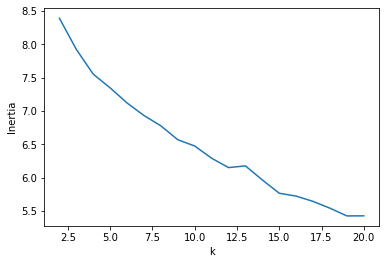

In [126]:
k_list = list(range(k_min,k_max+1))
plt.xlabel('k')
plt.ylabel('Inertia')
fig = plt.plot(np.array(k_list), np.array(inertia_list))
plt.savefig('inertia plot.png')

In [132]:
# Based roughly on the 'k vs Inertia' plot, although it seems
# there is no apparent elbow point, let's choose 8
# Cluster the neighborhoods into 8 groups
kclusters = 8

kmeans = KMeans(init = 'k-means++', n_clusters = kclusters, n_init = 12)
kmeans.fit(tokyo_grouped_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [133]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
except:
    pass
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# create new dataframe named tokyo_merged
tokyo_merged = tokyo_df.copy(deep=True)

# Drop the neighborhoods that has fewer than 10 venues from tokyo_merged dataframe
n_neigh_before = tokyo_merged.shape[0]
for index, row in venues_to_drop.iterrows():
    #print(index)
    tokyo_merged = tokyo_merged[tokyo_merged.Neighborhood != index]
print('Number of neighborhoods dropped is {} (supposed to be {})'.format(n_neigh_before-tokyo_merged.shape[0],
                                                                        venues_to_drop.shape[0]))
print(n_neigh_before, tokyo_merged.shape[0])

# merge tokyo_merged dataframe with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tokyo_merged.to_csv('tokyo_merged.csv')

Number of neighborhoods dropped is 11 (supposed to be 11)
246 235


In [144]:
# read tokyo_merged.csv
tokyo_merged = pd.read_csv('tokyo_merged.csv')
tokyo_merged.drop('Unnamed: 0', axis=1, inplace=True)
tokyo_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Senju, Adachi,",35.748916,139.804754,0,Sake Bar,Ramen Restaurant,Convenience Store,Japanese Restaurant,Café,Coffee Shop,Japanese Curry Restaurant,Burger Joint,Pharmacy,Vietnamese Restaurant
1,"Hongō, Bunkyo,",35.706617,139.759913,0,Ramen Restaurant,Udon Restaurant,Café,BBQ Joint,Italian Restaurant,Szechuan Restaurant,Noodle House,Gym / Fitness Center,Wagashi Place,Convenience Store
2,"Kasuga, Bunkyo,",35.708525,139.752735,0,Convenience Store,Baseball Stadium,Ramen Restaurant,Japanese Restaurant,Coffee Shop,BBQ Joint,Concert Hall,Sake Bar,Italian Restaurant,Bakery
3,"Koishikawa, Bunkyo,",35.705363,139.749111,0,Baseball Stadium,Ramen Restaurant,Café,Japanese Restaurant,Coffee Shop,Convenience Store,Garden,Bakery,Spa,Betting Shop
4,"Koraku, Bunkyo,",35.706373,139.746906,2,Convenience Store,Japanese Restaurant,Intersection,Hotel,Garden,Indian Restaurant,Dumpling Restaurant,Szechuan Restaurant,Toll Booth,Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,"Ichigaya-Yanagi-chō, Shinjuku,",35.699029,139.726448,2,Convenience Store,Italian Restaurant,Ramen Restaurant,Café,Sake Bar,Park,Drugstore,Vegetarian / Vegan Restaurant,French Restaurant,Grocery Store
231,"Kasumigaokamachi‎, Shinjuku,",35.676911,139.716464,0,Baseball Stadium,Park,Convenience Store,Athletics & Sports,Playground,Café,Takoyaki Place,Baseball Field,Art Museum,Sporting Goods Shop
232,"Kawada-chō, Shinjuku,",35.696821,139.719286,1,Convenience Store,Coffee Shop,Fast Food Restaurant,Supermarket,Arts & Crafts Store,Ramen Restaurant,Spanish Restaurant,Café,Italian Restaurant,Pharmacy
233,"Sumiyoshi-chō, Shinjuku,",35.693621,139.721005,1,Convenience Store,Ramen Restaurant,Sake Bar,BBQ Joint,Donburi Restaurant,Grocery Store,Chinese Restaurant,Bed & Breakfast,Tonkatsu Restaurant,Sushi Restaurant


In [129]:
# Get the latitude and longitude of Tokyo
try:
    address = 'Tokyo, Japan'
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
except:
    latitude = 35.6828
    longitude = 139.7594
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of Tokyo, Japan are 35.6828387, 139.7594549.


In [145]:
# drop any nan value just in case
tokyo_merged_nonan = tokyo_merged.dropna()
tokyo_merged_nonan.head(10)
print("{} rows are dropped due to nan".format(tokyo_merged.shape[0] - tokyo_merged_nonan.shape[0]))

0 rows are dropped due to nan


In [148]:
# create map for Tokyo and add neighborhoods along with their label
map_clusters = folium.Map(location=[latitude, longitude], control_scale=True, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [3*i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# define manual colors
clrs = ['red','blue','yellow','orange','brown','black','green','cyan','olive','blueviolet']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged_nonan['Latitude'], tokyo_merged_nonan['Longitude'], tokyo_merged_nonan['Neighborhood'], tokyo_merged_nonan['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        # use user-defined manual colors
        #color=rainbow[int(cluster)-1],
        color=clrs[int(cluster)],
        fill=True,
        #fill_color=rainbow[int(cluster)-1],
        fill_color = clrs[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [142]:
# check the columns to include
cluster = tokyo_merged_nonan.loc[tokyo_merged_nonan['Cluster Labels'] == label, tokyo_merged_nonan.columns[[1] + list(range(4, tokyo_merged_nonan.shape[1]))]]
cluster

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()


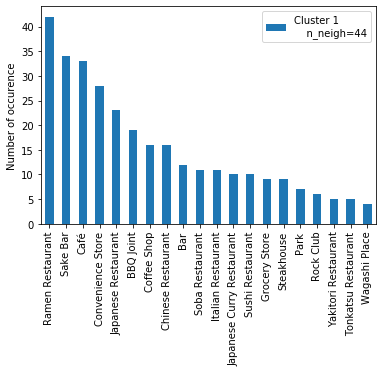

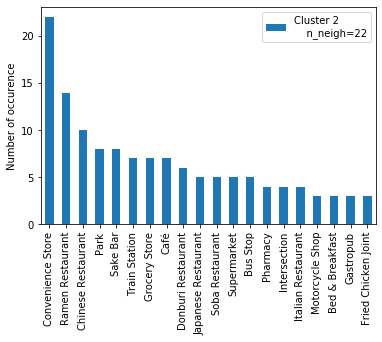

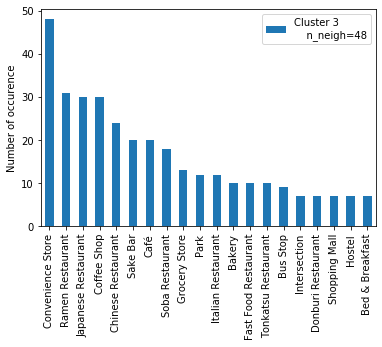

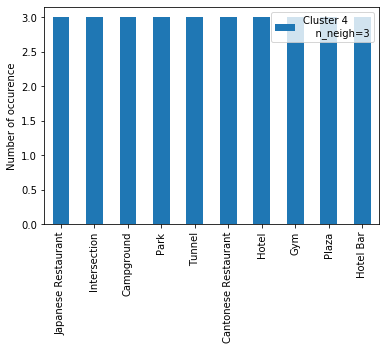

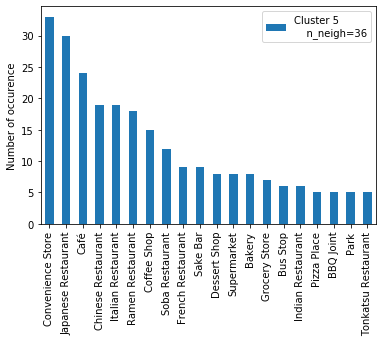

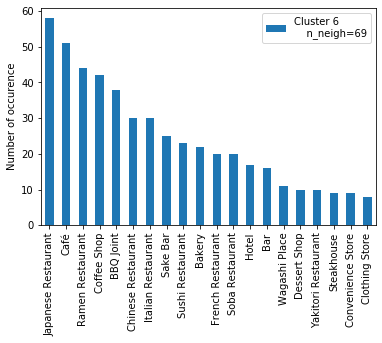

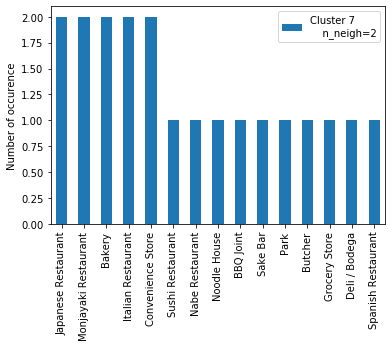

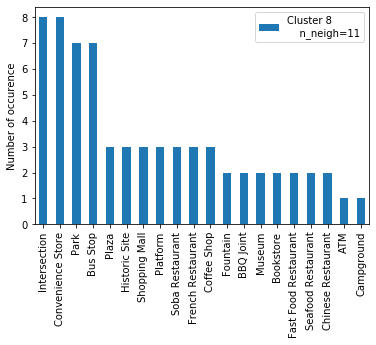

In [147]:
# Get most frequent "n_top" venue categories in EACH CLUSTER and save them as table and figure
# to analyze each cluster
n_top = 20
import matplotlib.pyplot as plt
for label in range(0,kclusters):
    one_based_ind = label + 1
    cluster = tokyo_merged_nonan.loc[tokyo_merged_nonan['Cluster Labels'] == label, tokyo_merged_nonan.columns[[1] + list(range(4, tokyo_merged_nonan.shape[1]))]]
    n_neighs = cluster.shape[0]
    cluster_series = pd.Series(cluster.drop('Latitude', axis = 1).values.flatten())
    venue_category_count = cluster_series.value_counts()
    venue_category_count.to_csv('Cluster{}_venue_category_counts.csv'.format(one_based_ind))
    fig, ax = plt.subplots()
    lgnd = """Cluster {}
    n_neigh={}""".format(one_based_ind,n_neighs)
    venue_category_count.iloc[0:n_top].plot(ax=ax, kind='bar', label = lgnd)
    ax.legend(loc='upper right')
    ax.set_ylabel('Number of occurence')
    
    ax.get_figure().savefig('Cluster{}_figure.png'.format(one_based_ind), bbox_inches='tight')
    

## 4. Alternative KMeans clustering based on collapsed features

***NOTE*** : This section is not included in the report!.


It can be seen that in many clusters above, variety of restaurants seem to be popular venues in each neighborhood. Since there are many variants of restaurants such as Italian, Mexican, Chinese, Ramen restaurant etc, it will be interesting to group all features that contain a word 'Restaurant' into single feature named 'Restaurant'.

In this alternative clustering, I will collapse all features containing a word 'Restaurant' into single feature named 'Restaurant'.

In specific, for example, if there are 3 venues with venue category Italian Restaurant, Chinese Restaurant, and Ramen Restaurant, respectively, in a neighborhood A, then after collapsing there will be 3 venues under a single venue category 'Restaurant'.

### 3.1. Collapsing the features

In [106]:
tokyo_grouped_collapsed = tokyo_grouped.copy(deep=True)
tokyo_grouped_collapsed['Temp_rest_sum'] = 0.0
for column in tokyo_grouped_collapsed:
    if 'restaurant' in column.lower():
        tokyo_grouped_collapsed['Temp_rest_sum'] += tokyo_grouped_collapsed[column]

print('Original shape is {} and temporary new shape is {}'.format(tokyo_grouped.shape, tokyo_grouped_collapsed.shape))

Original shape is (235, 365) and temporary new shape is (235, 366)


In [107]:
# start removing the collapsed features (i.e venue categories)
for column in tokyo_grouped_collapsed:
    if 'restaurant' in column.lower():
        tokyo_grouped_collapsed.drop(column, axis=1, inplace = True)

In [108]:
# now, rename temporary column 'Temp_restaurant_sum' to 'Restaurant'
tokyo_grouped_collapsed.rename({'Temp_rest_sum': 'Restaurant'}, axis=1, inplace=True)
tokyo_grouped_collapsed.to_csv('tokyo_grouped_collapsed.csv')

In [109]:
# read tokyo_grouped_collapsed.csv
tokyo_grouped_collapsed = pd.read_csv('tokyo_grouped_collapsed.csv')
tokyo_grouped_collapsed.drop('Unnamed: 0', axis=1, inplace=True)
tokyo_grouped_collapsed.shape

(235, 279)

In [110]:
print('Number of collapsed features is {}'.format(tokyo_grouped.shape[1]-tokyo_grouped_collapsed.shape[1]+1))
tokyo_grouped_collapsed.shape

Number of collapsed features is 87


(235, 279)

In [111]:
# make sure that sum over all features is 1.0 (because it's venue category frequency,
# so the sum must be 1.0)
tokyo_grouped_collapsed.sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
230    1.0
231    1.0
232    1.0
233    1.0
234    1.0
Length: 235, dtype: float64

In [112]:
# Retrieve top 10 venues for each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_collapsed_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_collapsed_sorted['Neighborhood'] = tokyo_grouped_collapsed['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_collapsed_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped_collapsed.iloc[ind, :], num_top_venues)

neighborhoods_venues_collapsed_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Akabane, Kita,",Restaurant,Sake Bar,Convenience Store,Coffee Shop,BBQ Joint,Shopping Mall,Bar,Supermarket,Tea Room,Café
1,"Akasaka, Minato,",Restaurant,BBQ Joint,Coffee Shop,Bar,Steakhouse,Café,Bed & Breakfast,Hotel,Dessert Shop,Sake Bar
2,"Akashichō, Chuo,",Restaurant,Convenience Store,Bakery,Park,Shopping Mall,Hobby Shop,Bar,Noodle House,Bed & Breakfast,Sake Bar
3,"Akihabara, Taito,",Restaurant,Sake Bar,BBQ Joint,Hobby Shop,Dessert Shop,Café,Pub,Steakhouse,Train Station,Music Store
4,"Aomi, Koto,",Exhibit,Restaurant,Plaza,Park,Bookstore,Shopping Mall,Coffee Shop,Convenience Store,Rock Club,Tea Room


In [113]:
# save neighborhoods_venues_collapsed_sorted dataframe
neighborhoods_venues_collapsed_sorted.to_csv('neighborhoods_venues_collapsed_sorted.csv')

In [114]:
# read neighborhoods_venues_sorted data
neighborhoods_venues_collapsed_sorted = pd.read_csv('neighborhoods_venues_collapsed_sorted.csv')
neighborhoods_venues_collapsed_sorted.drop('Unnamed: 0', axis=1, inplace=True)
neighborhoods_venues_collapsed_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Akabane, Kita,",Restaurant,Sake Bar,Convenience Store,Coffee Shop,BBQ Joint,Shopping Mall,Bar,Supermarket,Tea Room,Café
1,"Akasaka, Minato,",Restaurant,BBQ Joint,Coffee Shop,Bar,Steakhouse,Café,Bed & Breakfast,Hotel,Dessert Shop,Sake Bar
2,"Akashichō, Chuo,",Restaurant,Convenience Store,Bakery,Park,Shopping Mall,Hobby Shop,Bar,Noodle House,Bed & Breakfast,Sake Bar
3,"Akihabara, Taito,",Restaurant,Sake Bar,BBQ Joint,Hobby Shop,Dessert Shop,Café,Pub,Steakhouse,Train Station,Music Store
4,"Aomi, Koto,",Exhibit,Restaurant,Plaza,Park,Bookstore,Shopping Mall,Coffee Shop,Convenience Store,Rock Club,Tea Room


In [115]:
# Cluster using K-means
# First, see how different k value affects the clustering in terms of 'inertia'
k_min, k_max = 2, 20
tokyo_grouped_collapsed_clustering = tokyo_grouped_collapsed.drop('Neighborhood', 1)
inertia_list = []

for k in range(k_min, k_max+1):
    kmeans = KMeans(init = 'k-means++', n_clusters = k, n_init = 12)
    kmeans.fit(tokyo_grouped_collapsed_clustering)
    inertia_list.append(kmeans.inertia_)
    print('k={}: inertia={}'.format(k,kmeans.inertia_))
# run k-means clustering


# check cluster labels generated for each row in the dataframe
#tokyo_grouped_collapsed_clustering

k=2: inertia=8.12420469715833
k=3: inertia=6.978790302922292
k=4: inertia=6.205133048107511
k=5: inertia=5.838030825534686
k=6: inertia=5.5000190632247685
k=7: inertia=5.307118151696492
k=8: inertia=5.131771468734364
k=9: inertia=4.9484012458554405
k=10: inertia=4.84510253333217
k=11: inertia=4.692331965840566
k=12: inertia=4.550380822426222
k=13: inertia=4.4253096025832726
k=14: inertia=4.301174195047846
k=15: inertia=4.212826177079264
k=16: inertia=4.093535520539962
k=17: inertia=4.017644235053246
k=18: inertia=3.9359446793979087
k=19: inertia=3.8694130420576673
k=20: inertia=3.8412467456418344


,ATM,Acai House,Accessories Store,Adult Boutique,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Restaurant
0,0.0,0.0,0.0,0.00,0.0,0.0,0.01,0.000000,0.000000,0.00,...,0.0,0.00,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.310000
1,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,...,0.0,0.00,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.614583
2,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,...,0.0,0.00,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.697674
3,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.000000,0.000000,0.00,...,0.0,0.01,0.010000,0.00,0.000000,0.0,0.00,0.0,0.0,0.300000
4,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.018868,0.00,...,0.0,0.00,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.132075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,...,0.0,0.00,0.000000,0.00,0.000000,0.0,0.01,0.0,0.0,0.410000
231,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.010000,0.010000,0.00,...,0.0,0.00,0.010000,0.01,0.000000,0.0,0.00,0.0,0.0,0.380000
232,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.013514,0.000000,0.00,...,0.0,0.00,0.013514,0.00,0.013514,0.0,0.00,0.0,0.0,0.405405
233,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,...,0.0,0.00,0.023256,0.00,0.000000,0.0,0.00,0.0,0.0,0.372093


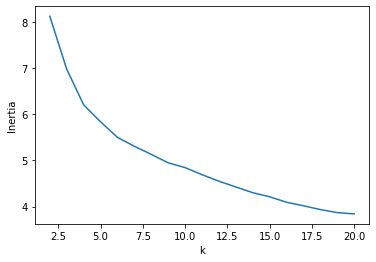

In [116]:
k_list = list(range(k_min,k_max+1))
plt.xlabel('k')
plt.ylabel('Inertia')
fig = plt.plot(np.array(k_list), np.array(inertia_list))
plt.savefig('inertia plot collapsed.png')
plt.show()

In [152]:
# Based roughly on the 'k vs Inertia' plot, it seems elbow point can be around 6
# Cluster the neighborhoods into 6 groups
kclusters = 6

kmeans = KMeans(init = 'k-means++', n_clusters = kclusters, n_init = 12)
kmeans.fit(tokyo_grouped_collapsed_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [119]:
# add clustering labels
try:
    neighborhoods_venues_collapsed_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
except:
    pass
neighborhoods_venues_collapsed_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged_collapsed = tokyo_df.copy(deep=True)

# Drop the neighborhoods that has fewer than 10 venues from tokyo_merged_collapsed dataframe
n_neigh_before = tokyo_merged_collapsed.shape[0]
for index, row in venues_to_drop.iterrows():
    #print(index)
    tokyo_merged_collapsed = tokyo_merged_collapsed[tokyo_merged_collapsed.Neighborhood != index]
print('Number of neighborhoods dropped is {} (supposed to be {})'.format(n_neigh_before-tokyo_merged_collapsed.shape[0],
                                                                        venues_to_drop.shape[0]))
print(n_neigh_before, tokyo_merged_collapsed.shape[0])

# merge tokyo_merged_collapsed dataframe with neighborhoods_venues_collapsed_sorted to add latitude/longitude for each neighborhood
tokyo_merged_collapsed = tokyo_merged_collapsed.join(neighborhoods_venues_collapsed_sorted.set_index('Neighborhood'), on='Neighborhood')

tokyo_merged_collapsed.to_csv('tokyo_merged_collapsed.csv')

Number of neighborhoods dropped is 11 (supposed to be 11)
246 235


In [150]:
tokyo_merged_collapsed = pd.read_csv('tokyo_merged_collapsed.csv')
tokyo_merged_collapsed.drop('Unnamed: 0', axis=1, inplace=True)
tokyo_merged_collapsed

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Senju, Adachi,",35.748916,139.804754,4,Restaurant,Sake Bar,Convenience Store,Café,Coffee Shop,Burger Joint,Ice Cream Shop,BBQ Joint,Shopping Mall,Bistro
1,"Hongō, Bunkyo,",35.706617,139.759913,0,Restaurant,Café,BBQ Joint,Convenience Store,Gym / Fitness Center,Soup Place,Noodle House,Candy Store,Wagashi Place,Sake Bar
2,"Kasuga, Bunkyo,",35.708525,139.752735,2,Restaurant,Convenience Store,Baseball Stadium,Coffee Shop,BBQ Joint,Bakery,Concert Hall,Sake Bar,Café,Bookstore
3,"Koishikawa, Bunkyo,",35.705363,139.749111,2,Restaurant,Baseball Stadium,Café,Coffee Shop,Bakery,Garden,Park,Spa,Convenience Store,Betting Shop
4,"Koraku, Bunkyo,",35.706373,139.746906,3,Restaurant,Convenience Store,Hotel,Intersection,Garden,Park,Toll Booth,Café,Discount Store,Diner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,"Ichigaya-Yanagi-chō, Shinjuku,",35.699029,139.726448,5,Restaurant,Convenience Store,Café,Sake Bar,Park,Grocery Store,Historic Site,Drugstore,Discount Store,Juice Bar
231,"Kasumigaokamachi‎, Shinjuku,",35.676911,139.716464,1,Baseball Stadium,Restaurant,Convenience Store,Park,Hotel,Beer Garden,Café,Sporting Goods Shop,Skating Rink,Baseball Field
232,"Kawada-chō, Shinjuku,",35.696821,139.719286,3,Convenience Store,Restaurant,Coffee Shop,Supermarket,Grocery Store,Steakhouse,Pharmacy,Arts & Crafts Store,Café,Fried Chicken Joint
233,"Sumiyoshi-chō, Shinjuku,",35.693621,139.721005,5,Restaurant,Convenience Store,Sake Bar,BBQ Joint,Grocery Store,Bakery,Drugstore,Coffee Shop,Climbing Gym,Café


In [151]:
# create map for Tokyo
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# define manual colors
clrs = ['red','blue','yellow','orange','brown','black','green','cyan','olive','blueviolet']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged_collapsed['Latitude'], tokyo_merged_collapsed['Longitude'], tokyo_merged_collapsed['Neighborhood'], tokyo_merged_collapsed['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        # use manual colors
        #color=rainbow[int(cluster)-1],
        color=clrs[int(cluster)],
        fill=True,
        #fill_color=rainbow[int(cluster)-1],
        fill_color=clrs[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [123]:
cluster = tokyo_merged_collapsed.loc[tokyo_merged_collapsed['Cluster Labels'] == label, tokyo_merged_collapsed.columns[[1] + list(range(4, tokyo_merged_collapsed.shape[1]))]]
cluster

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # This is added back by InteractiveShellApp.init_path()


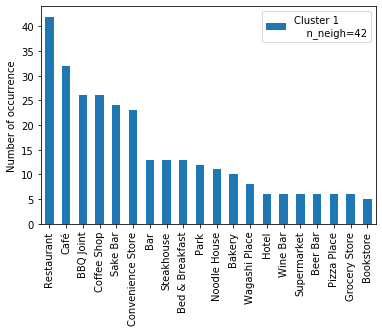

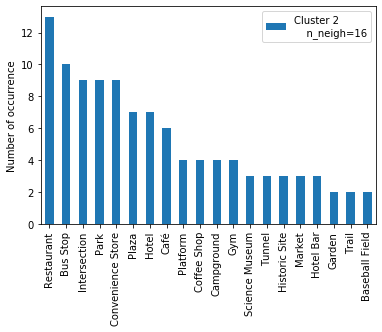

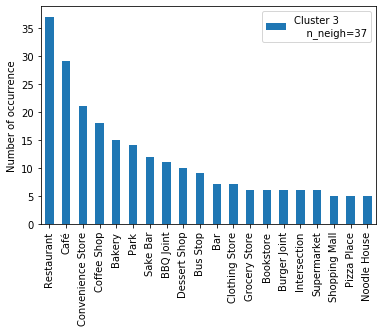

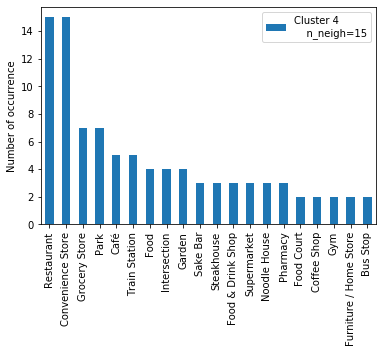

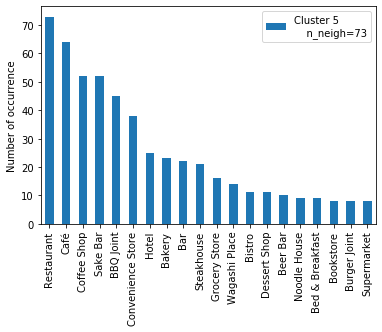

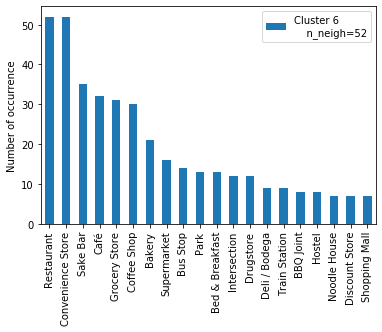

In [153]:
# Get most frequent "n_top" venue categories in each cluster and save them as table and figure
# to analyze each cluster
n_top = 20
import matplotlib.pyplot as plt
for label in range(0,kclusters):
    one_based_ind = label + 1
    cluster = tokyo_merged_collapsed.loc[tokyo_merged_collapsed['Cluster Labels'] == label, tokyo_merged_collapsed.columns[[1] + list(range(4, tokyo_merged_collapsed.shape[1]))]]
    n_neigh = cluster.shape[0]
    cluster_series = pd.Series(cluster.drop('Latitude', axis = 1).values.flatten())
    venue_category_count = cluster_series.value_counts()
    venue_category_count.to_csv('Cluster{}_collapsed_venue_category_counts.csv'.format(one_based_ind))
    fig, ax = plt.subplots()
    lgnd = """Cluster {}
    n_neigh={}""".format(one_based_ind,n_neigh)
    venue_category_count.iloc[0:n_top].plot(ax=ax, kind='bar', label = lgnd)
    ax.legend(loc='upper right')
    ax.set_ylabel('Number of occurrence')
    
    ax.get_figure().savefig('Cluster{}_figure_collapsed.png'.format(one_based_ind), bbox_inches='tight')
    